## Comparing QForce
This notebook does visual comparison of qforce with other layouts, or QForce using different parameters with each other. It uses Cytoscape via Py4Cytoscape to visualize the outputs. It also compares the speed of the layouts.

It is centered around a "compare" function that accepts (1) dict of parameters for layout 1, (2) a dict of parameters for layout 2, and (3) a list of input CX files.  By default, it runs QForce vs Cytoscape Prefuse with default parameters on a set of test networks in the data folder.

## Imports

In [49]:
import os
import sys
import ndex2
import json
import py4cytoscape as py4
import time
import tempfile
from IPython import display
import qflayout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Test Networks

In [67]:
test_network_files = ["test_nectin_adhesion.cx"]
test_networks = []
def load_test_cx(filename):
    print(filename)
    #path = str(os.path.join("tests/data/" + filename))
    #script_dir = os.path.dirname(__file__) #<-- absolute dir this script is in
    #rel_path = "tests/data/" + filename
    path = os.path.join(os.getcwd(), "tests", "data", filename)
    return ndex2.create_nice_cx_from_file(path)
    err_stream = sys.stderr
    if path is None or not os.path.isfile(path):
        err_stream.write(str(path) + ' is not a file')
        return None
        
    if os.path.getsize(path) == 0:
        err_stream.write(str(path) + ' is an empty file')
        return None

    try:
        return ndex2.create_nice_cx_from_file(path)
    except Exception as e:
        err_stream.write(str(e))
        return None
    finally:
        err_stream.flush()    


# importing os module
import os
  
# gives the path of demo.py
path = os.path.realpath(__file__)
  
# gives the directory where demo.py 
# exists
dir = os.path.dirname(path)
  
# replaces folder name of Sibling_1 to 
# Sibling_2 in directory
dir = dir.replace('Sibling_1', 'Sibling_2')
  
# changes the current directory to 
# Sibling_2 folder
os.chdir(dir)
  
# opening file.txt which is to read
f = open('file.txt')
  
# reading data from file.txt and storing
# it in data
data = f.read()
  
# printing data
print(data)

for filename in test_network_files:
    cx_network = load_test_cx(filename)
    if cx_network is not None:
        test_networks.append(cx_network)

test_networks

test_nectin_adhesion.cx


Exception: The file c:\Users\depra\Dropbox\GitHub\cdqforcelayout\cdqforcelayout\tests\data\test_nectin_adhesion.cx  does not exist.

## Open Networks in Cytoscape
Export Networks as files
Import to Cytoscape
clean up

In [53]:
def save_nice_cx_as_cx_file(network):
    filename = str(os.path.join(network.get_name(), ".cx"))
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(network.to_cx(), f, ensure_ascii=False, indent=4)

def open_cx_networks_in_cytoscape(networks):
    for network in networks:
        print("opening: " + network.get_name())
        save_nice_cx_as_cx_file(network)
        py4.import_network_from_file(filename)
        if os.path.exists(filename):
            os.remove(filename)
        else:
            print("The cx file we just wrote does not exist!")

In [57]:
print(test_networks)
open_cx_networks_in_cytoscape(test_networks)

[]


## Output the network as an image using Cytoscape
Use Py4Ctyoscape to 
* Send the network to Cytoscape
* Create a view
* Generate the image and return
* Clean up Cytoscape by deleting the network and its view

In [5]:
# verify cytoscape is alive
sys.stdout.write('Cytoscape status: ' + str(py4.cytoscape_ping()) + '\n\n')
# send the first test network
# load NeST network
# https://www.ndexbio.org/v2/network/9a8f5326-aa6e-11ea-aaef-0ac135e8bacf
sys.stdout.write('Loading NeST network from NDEx\n\n')
net_suid = py4.cy_ndex.import_network_from_ndex('9a8f5326-aa6e-11ea-aaef-0ac135e8bacf')
sys.stdout.write('suid of imported network: ' + str(net_suid) + '\n\n')


You are connected to Cytoscape!
Cytoscape status: You are connected to Cytoscape!

Loading NeST network from NDEx

suid of imported network: 442730



In [47]:
def wait_on_panel_to_be_in_docked_state(panel_name, num_tries=50, retry_wait=0.1):
    """
    Waits for panel to be in docked state
    :param panel_name: name of panel ie SOUTH, WEST, control panel, etc.
    :param num_tries: Number of times to check status
    :param retry_wait: how long in seconds to wait
    :type retry_wait: float
    :return: True if panel is in DOCK state otherwise False
    """
    for x in range(num_tries):
        time.sleep(retry_wait)
        res = py4.cyrest_get('ui/panels', require_json=True)
        pdict = {}
        # build dict
        for panel in res:
            pdict[panel['name']] = panel['state']

        # check if panel is in DOCK state
        if pdict[panel_name] == 'DOCK':
            return True
    return False

def display_network_image(suid):
    # redock the control panel and table panel
    # cause when we do fit content the annotations are not considered and
    # are often outside the window
    py4.cyrest_put('ui/panels',
                body=[
                        {
                            "name": "WEST",
                            "state": "DOCK"
                        }], require_json=False)

    wait_on_panel_to_be_in_docked_state('WEST')

    py4.cyrest_put('ui/panels',
                body=[
                        {
                            "name": "SOUTH",
                            "state": "DOCK"
                        }], require_json=False)

    wait_on_panel_to_be_in_docked_state('SOUTH')

    # adding another wait cause UI does not react :(
    time.sleep(5)

    tempfilename = str(suid) + ".png"
    res = py4.network_views.export_image(tempfilename, type='PNG', width=4000, network=net_suid)
    sys.stdout.write('result of export image: ' + str(res) + '\n')
    return res["file"]

    # export image of network as a png in a temporary directory
    # display the png
    # the png will be deleted along with the directory when we 
    # leave the scope of the with
    #
"""     with tempfile.TemporaryDirectory() as tmpdirname:
        sys.stdout.write('created temporary directory: ' + tmpdirname + '\n')
        path = os.path.join(tmpdirname, str(suid)) #+ '.png')
        sys.stdout.write("and this file path: " + str(path))
        res = py4.network_views.export_image(path, type='PNG', width=4000, network=net_suid)
        sys.stdout.write('result of export image: ' + str(res) + '\n')
        display.Image("./image.png") """

def display_ndex_network(uuid):
    net_suid = py4.cy_ndex.import_network_from_ndex(uuid)
    sys.stdout.write('suid of imported network: ' + str(net_suid) + '\n\n')
    try:
        image_file = display_network_image(net_suid)
        img = mpimg.imread(image_file)
        imgplot = plt.imshow(img)
        plt.show()
        #display.Image[image_file]
    # clean up Cytoscape
    finally:
        py4.delete_network(network=net_suid)


suid of imported network: 496670

result of export image: {'file': 'C:\\Users\\depra\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\496670.png'}


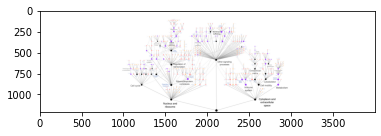

In [48]:
net_uuid = '9a8f5326-aa6e-11ea-aaef-0ac135e8bacf'
display_ndex_network(net_uuid)

In [33]:
with tempfile.TemporaryDirectory() as tmpdirname:
        sys.stdout.write('created temporary directory: ' + tmpdirname + '\n')
        isdir = os.path.isdir(tmpdirname)
        print("isdir " + str(isdir))
        path = os.path.join(tmpdirname, "foo.txt") #+ '.png')
        sys.stdout.write("and this file path: " + str(path) + '\n')
        f = open(path, "a")
        f.write("this is a test")
        f.close()
        f = open(path, "r")
        print(f.read())
        f.close()

created temporary directory: C:\Users\depra\AppData\Local\Temp\tmpu_wwx7hv
isdir True
and this file path: C:\Users\depra\AppData\Local\Temp\tmpu_wwx7hv\foo.txt
this is a test


In [36]:
f = open("foo.txt", "a")
f.write("this is a test")
f.close()
f = open("foo.txt", "r")
print(f.read())
f.close()
if os.path.exists("foo.txt"):
  os.remove("foo.txt")
else:
  print("The file does not exist")

this is a testthis is a testthis is a test


In [42]:
img = mpimg.imread('C:\\Users\\depra\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\491276.png')
imgplot = plt.imshow(img)
plt.show()

 """    display.Image(res["file"])
    if os.path.exists(res["file"]):
        os.remove(res["file"]) """

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\depra\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\491276.png'